# Chess games data analysis

## Motivation

The intention of this data analysis is to build a model that, given information about a Chess game's initial configuration, can suggest opening sequences that result in higher likelihoods of success.  Although the model won't be able to make highly-accurate predictions about a game's winner before the game is played, it should be able to confidently rank the opening moves to provide players with a little guidance on how to start their games.

## Imports

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
import urllib
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading the data

The data has been originally sourced from [Kaggle](https://www.kaggle.com/datasnaek/chess) and is hosted on [GitHub](https://github.com/ChrisJMurdoch/ChessGameData) for convenience.

To speed up this part for multiple runs, you can clone the repository to ./data/

In [2]:
LOCAL_SRC = "./data/"
GITHUB_SRC = "https://raw.githubusercontent.com/ChrisJMurdoch/ChessGameData/main/"

In [3]:
try: # Try getting the data locally
    data = pd.read_csv(LOCAL_SRC+"chess_data.csv", index_col=0)
    
except: # Default to GitHub repo
    data = pd.read_csv(GITHUB_SRC+"chess_data.csv", index_col=0)

In [4]:
# Rename some of the lengthier column names
data = data.rename(columns={
    "created_at":"start",
    "last_move_at":"end",
    "victory_status": "status",
    "opening_eco": "eco"
})

## Improving the data

Some useful data can be inferred from existing columns to provide more meaningful results.

### Time and increment

In chess, the time that each player has to make their move is variable.  In the original data, this data is stored as a single string in the form:

 - 10+5 : Each person starts with 10 minutes on their clock, and 5 seconds is added each turn
 - 0+10 : Start with no time on clock, add 10 seconds each turn
 - and so on...

As this does not allow the time and increment values to be recognised as ratio values, we should separate them into columns like so:

In [5]:
data["time"]      = data["increment_code"].apply( lambda code : int(code.split("+")[0])*60 )
data["increment"] = data["increment_code"].apply( lambda code : int(code.split("+")[1]) )

### Start and end times

The columns start and end timestamps should provide good information on when the game was played and how long it lasted.  Unfortunately, the values are stored as floating-point numbers with precision far too low to give meaningful results on duration.  As can be seen below, 43% of the rows report the end time to be exactly the same as the start time.

In [6]:
zero_duration = data["end"] == data["start"]
zero_duration.value_counts(normalize=True)*100

False    57.383588
True     42.616412
dtype: float64

Although we can't get the amount of time the players took to finish the game, we can calculate how much time was available to the players.

Because the time column represents the number of minutes each player has on their clock at the start of the game, and because increment represents the amount of seconds added at the start of their turn, the game's maximum duration can be calculated like so:

In [7]:
data["max_duration"] = (data["time"]*2) + (data["turns"]*data["increment"])
data["max_duration"] = data["max_duration"].clip(upper=20.25*60*60)

Note that the time has been capped at 20.25 hours<sup>1</sup>.  As no player should exceed this time, there is no point in differentiating a player with 21 hours on the clock and one with 100 hours.

<sup>1</sup> [The longest official chess game had 269 moves and lasted 20 hours and 15 minutes.](https://en.wikipedia.org/wiki/List_of_world_records_in_chess)

### Game winner

As winning, drawing and losing in a zero-sum game like chess is easy to quantify, we can change the winner column to a numerical value.  This allows us to calculate the mean winner when aggregating the data.  We can also calculate the difference in ratings into a column so that the difference is preserved when the data is grouped.

In [8]:
data = data.replace({ "winner" : {"white":1, "draw":0, "black":-1} })
data["rating_delta"] = data["white_rating"] - data["black_rating"]

## Cleaning up the data

Before the data is displayed, a few of the unnecessary parts can be removed:


In [9]:
# Drop the columns that aren't needed
data = data.drop([
    'status',               # This allows the classifier to cheat and detect draws easily
    'start', 'end',         # These floats are too low-accuracy to provide meaningful results
    'increment_code',       # Replaced by time and increment
    'white_id', 'black_id', # Player names aren't relevant to this analysis
    'moves',                # This data is complex but may be used later
    'opening_name'          # This can be inferred from opening_eco
], axis=1)

# Change to a more intuitive column order
data = data[[
    "rated", "winner",
    "white_rating", "black_rating", "rating_delta",
    "eco", "opening_ply",
    "turns", "time","increment", "max_duration"
]]

### Invalid rows

To ensure that the data works with the neural network, all of the cells must have valid data in them.  Fortunately, as can be seen below, the data set comes with no incomplete or invalid data.

In [10]:
data[data.isnull().any(axis=1)].head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,


## Describing the data

In [11]:
data.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,False,1,1500,1191,309,D10,5,13,900,2,1826
l1NXvwaE,True,-1,1322,1261,61,B00,4,16,300,10,760
mIICvQHh,True,1,1496,1500,-4,C20,3,61,300,10,1210
kWKvrqYL,True,1,1439,1454,-15,D02,3,61,1200,0,2400
9tXo1AUZ,True,1,1523,1469,54,C41,5,95,1800,3,3885


As can be seen above, the data consists of 11 rows:
 - **rated (nominal)**: If the game was ranked by skill
 - **winner (ratio)**: Who won the game
 - **white_rating (interval)**: Skill rating of white player
 - **black_rating (interval)**: Skill rating of black player
 - **rating_delta (ratio)**: Difference in skill ratings (white-black)
 - **eco (nominal)**: ECO code for game opening used
 - **opening_ply (ratio)**: How many moves conformed to the opening sequence
 - **turns (ratio)**: How many turns the game lasted
 - **time (ratio)**: How many seconds each player started with on their clock
 - **increment (ratio)**: How many seconds each player gained at the start of their turn
 - **max_duration (ratio)**: The maximum duration the game could have lasted

In [12]:
from pandas.plotting import scatter_matrix

# Used to colour graph: https://stackoverflow.com/a/50703596
corr = data.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style
 .set_precision(2)
 .background_gradient(cmap='PRGn', axis=None, vmin=-.5, vmax=.5)
 .highlight_null(null_color='#f1f1f1'))

,rated,winner,white_rating,black_rating,rating_delta,opening_ply,turns,time,increment,max_duration
rated,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
winner,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan
white_rating,0.00,0.14,nan,nan,nan,nan,nan,nan,nan,nan
black_rating,0.03,-0.17,0.63,nan,nan,nan,nan,nan,nan,nan
rating_delta,-0.03,0.36,0.43,-0.43,nan,nan,nan,nan,nan,nan
opening_ply,-0.00,0.02,0.28,0.26,0.03,nan,nan,nan,nan,nan
turns,0.09,-0.04,0.13,0.16,-0.04,0.06,nan,nan,nan,nan
time,-0.11,0.01,-0.07,-0.08,0.01,-0.03,-0.06,nan,nan,nan
increment,-0.10,0.01,-0.02,-0.03,0.01,-0.01,-0.06,0.47,nan,nan
max_duration,-0.11,0.01,-0.05,-0.06,0.00,-0.02,0.00,0.95,0.64,nan


Some correlations that are immediately apparent are:

 - Skill ratings and the winner - higher skill results in higher win chance
 - White and black skill ratings - ranked games pit similarly-rated opponents against each other
 - Rating delta with skill ratings and winner - delta is an engineered attribute from these columns
 - Turns positively correlate with rated games - this may be because players concede/leave less in important rated games
 - Turns and skill rating - Higher skill ratings mean that game-forfeiting mistakes aren't made so often
 - Opening plays and skill rating - higher-skill players will use standard opening moves more often
 - Negative correlation between time limits and rated - not sure about this yet

## Aggregating the data

By grouping the data by the opening code (ECO), we can see that some openings are a lot more effective than others.

In [13]:
# Create new column to count unique occurrences (can't use index with agg())
data["unique"] = data.index

# Group by ECO code
grouped = data.groupby('eco').agg({'winner':'mean', 'unique':'size'})

# Discard counting column
data = data.drop(['unique'], axis=1)

# Filter out the openings with few recorded uses
filtered = grouped[grouped["unique"] > 160]

# Display data sorted by mean win-rate for white
filtered = filtered.sort_values("winner")
filtered

,winner,unique
eco,,
B20,-0.171076,567
A00,-0.170804,1007
A45,-0.126984,252
B30,-0.114537,227
C20,-0.082963,675
B50,-0.066372,226
C50,-0.052045,538
B06,-0.039773,176
D00,-0.025710,739


Because the winner is stored as a ratio, we can find the mean winner of each opening sequence.  This data shows the opening with the highest win rate for white as the popular opening; Queen's Gambit.

<AxesSubplot:xlabel='eco'>

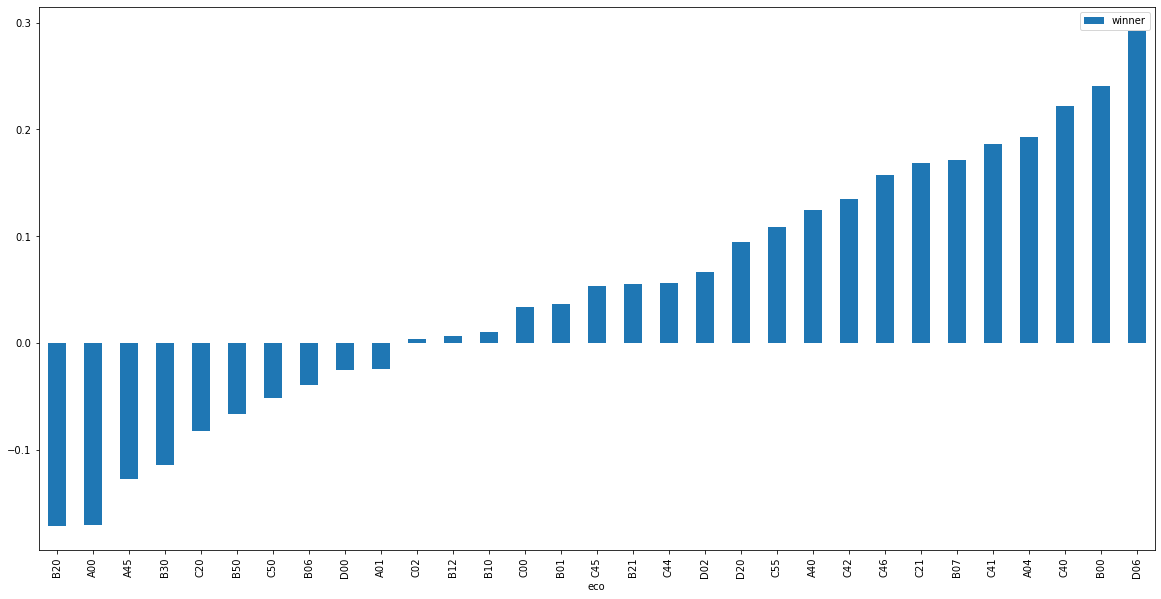

In [14]:
filtered.plot(kind="bar", use_index=True, y='winner', figsize=(20, 10))

Although some openings are more effective than others overall, some should prove to have differing effectiveness depending on the skill level of the user.  Hopefully, the neural network's analysis will reveal what openings are good for players of a certain skill range.

In [15]:
grouped = grouped.sort_values("unique")
grouped["unique"].describe()

count     365.000000
mean       54.953425
std       129.248506
min         1.000000
25%         3.000000
50%        10.000000
75%        36.000000
max      1007.000000
Name: unique, dtype: float64

## Preprocessing the data

To use Naive Bayes, all of the data must be in discrete, numerical form.  This means that continuous or near-continuous data must be put into discrete bins and all non-numerical values should be converted to numerical.

In [16]:
data.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,False,1,1500,1191,309,D10,5,13,900,2,1826
l1NXvwaE,True,-1,1322,1261,61,B00,4,16,300,10,760
mIICvQHh,True,1,1496,1500,-4,C20,3,61,300,10,1210
kWKvrqYL,True,1,1439,1454,-15,D02,3,61,1200,0,2400
9tXo1AUZ,True,1,1523,1469,54,C41,5,95,1800,3,3885


In [17]:
# Discretise and bin data
def discretise(data):
    discrete = data.copy()
    discrete['white_rating'] = pd.qcut(data['white_rating'], q=10, duplicates='drop')
    discrete['black_rating'] = pd.qcut(data['black_rating'], q=10, duplicates='drop')
    discrete['rating_delta'] = pd.qcut(data['rating_delta'], q=10, duplicates='drop')
    discrete['max_duration'] = pd.qcut(data['max_duration'], q=10, duplicates='drop')
    return discrete

discrete = discretise(data)
discrete.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,False,1,"(1441.0, 1500.0]","(788.999, 1226.0]","(293.0, 1499.0]",D10,5,13,900,2,"(1800.0, 2280.0]"
l1NXvwaE,True,-1,"(1236.0, 1351.0]","(1226.0, 1346.0]","(39.0, 89.0]",B00,4,16,300,10,"(31.999, 976.0]"
mIICvQHh,True,1,"(1441.0, 1500.0]","(1432.0, 1500.0]","(-29.0, 3.0]",C20,3,61,300,10,"(1200.0, 1430.0]"
kWKvrqYL,True,1,"(1351.0, 1441.0]","(1432.0, 1500.0]","(-29.0, 3.0]",D02,3,61,1200,0,"(2280.0, 3015.0]"
9tXo1AUZ,True,1,"(1500.0, 1567.0]","(1432.0, 1500.0]","(39.0, 89.0]",C41,5,95,1800,3,"(3015.0, 46260.0]"


In [18]:
# Numberise non-numerical columns
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
def numberise(data, include=None):
    if include:
        return data.apply(lambda x: encoder.fit_transform(x) if x.name in include else x)
    else:
        return data.apply(lambda x: encoder.fit_transform(x))

discrete = numberise(
    discrete,
    {'rated', 'status', 'white_rating', 'black_rating', 'rating_delta', 'eco', 'max_duration'}
)
discrete.head()

,rated,winner,white_rating,black_rating,rating_delta,eco,opening_ply,turns,time,increment,max_duration
id,,,,,,,,,,,
TZJHLljE,0,1,3,0,9,248,5,13,900,2,4
l1NXvwaE,1,-1,1,1,6,71,4,16,300,10,0
mIICvQHh,1,1,3,3,4,171,3,61,300,10,2
kWKvrqYL,1,1,2,3,4,241,3,61,1200,0,5
9tXo1AUZ,1,1,4,3,6,192,5,95,1800,3,6


## A note on classifier accuracy

Unlike other potential datasets, this set cannot have a near-perfect accuracy.  Where a dataset on bank loan approval may include all the data needed to make a very accurate prediction, this data on chess game variables only provides a clue as to who may win.  The winner is ultimately decided on how well the participants play.

Because the application of this classifier will be to suggest good openings to players given a set of game variables, the classifier will focus on making the best predictions possible with limited information.

## Using and evaluating the classifiers

Now that the data is in a form that Naive Bayes can work with, it's time to actually use the classifier.  We can use sklearn to quickly train and test the accuracy of a multinomial implementation of Naive Bayes:

In [19]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.model_selection import cross_val_score

# Evaluate score
scores = cross_val_score(MultinomialNB(), discrete.drop(['winner'], axis=1), discrete['winner'], cv=10, scoring="accuracy")
sum(scores) / len(scores)

0.40332993538088974

This is ok, but it can be improved.  Firstly, an accuracy of 0.4 is not as high as it could be which suggests we may be using the wrong implementation of Naive Bayes.  Secondly, the accuracy only shows the percentage of predictions it made that were correct.  It doesn't show other metrics such as how many correct instances it didn't predict.

To better visualise the performance of classifiers and attribute configurations, the following utility has been written to automate training the model, generate a confusion matrix, and report the relevant metrics.

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def classifier_metrics(classifier, data, class_name, attributes=None, folds=10, verbose=True):
    """
    Prints performance metrics for the given configuration
    @param classifier: The sklearn classifier with which to classify the data
    @param data: The pandas dataframe containing the instance data
    @param class_name: String stating the name of the column to be used as the output class
    @param attributes: Optional array of strings to specify which columns are to be used for classification
    """
    
    # Optionally get subset of attributes for attributes selection
    if attributes != None:
        if class_name not in attributes:
            attributes.append(class_name)
        data = data[attributes]
    
    # Separate model data from output
    model = data.drop([class_name], axis=1)
    output = data[class_name]
    
    # Print dataframe size
    attributes = len(model.columns)
    if verbose:
        print(f'Attributes: {attributes}')
    
    # Train classifier
    classifier.fit(model, output)
    
    # Get confusion matrix
    output_predict = cross_val_predict(classifier, model, output, cv=folds)
    confusion = confusion_matrix(output, output_predict)
    
    # Area under ROC curve
    roc = roc_auc_score(output, classifier.predict_proba(model), multi_class='ovr')
    if verbose:
        print (f'ROC AUC: {round(roc, 3)}')
    
    # Get precision, recall and f1 values
    if verbose:
        print (f'Class metrics:')
    sum_p, sum_r, sum_f = 0, 0, 0
    for i in range(len(confusion)):
        p, r, f = confusion_metrics(confusion, i)
        if verbose:
            print(f' - Class {i+1}: Precision: {round(p, 2)} Recall: {round(r, 2)} F1: {round(f, 2)}')
        sum_p += p
        sum_r += r
        sum_f += f
    s = len(confusion)
    avg_p = sum_p/s
    avg_r = sum_r/s
    avg_f = sum_f/s
    if verbose:
        print(f' - Average: Precision: {round(avg_p, 2)} Recall: {round(avg_r, 2)} F1: {round(avg_f, 2)}')
    return attributes, avg_p, avg_r, avg_f, roc
    
def confusion_metrics(cmat, index):
    """
    Returns performance metrics for a given confusion matrix and class index
    @param cmat: The confusion matrix from which to retrieve the data
    @param index: The index of the class being analysed
    """
    
    # Calculate basic values
    transpose = list(map(list, zip(*cmat)))
    tp = cmat[index][index]
    fp = sum(cmat[index]) - tp
    fn = sum(transpose[index]) - tp
    tn = sum(map(sum, cmat)) - (tp+fp+fn)
    
    # Calculate complex metrics
    precision = tp / (tp+fp)
    recall = (tp / (tp+fn)) if (tp+fn>0) else 0.0
    f1 = (2 * (precision*recall) / (precision+recall)) if (precision+recall>0) else 0.0
    
    return precision, recall, f1

## Using different classifiers

Now that we have a way to analyse different classifiers and configurations, we can try out a few of the standard implementations from sklearn:

In [21]:
multinomial10 = classifier_metrics(MultinomialNB(), discrete, 'winner')

Attributes: 10
ROC AUC: 0.587
Class metrics:
 - Class 1: Precision: 0.3 Recall: 0.57 F1: 0.39
 - Class 2: Precision: 0.47 Recall: 0.06 F1: 0.11
 - Class 3: Precision: 0.49 Recall: 0.59 F1: 0.54
 - Average: Precision: 0.42 Recall: 0.41 F1: 0.35


In [22]:
bernoulli10 = classifier_metrics(BernoulliNB(), discrete, 'winner')

Attributes: 10
ROC AUC: 0.6
Class metrics:
 - Class 1: Precision: 0.25 Recall: 0.7 F1: 0.37
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 0.92 Recall: 0.54 F1: 0.68
 - Average: Precision: 0.39 Recall: 0.42 F1: 0.35


In [23]:
gaussian10 = classifier_metrics(GaussianNB(), discrete, 'winner')

Attributes: 10
ROC AUC: 0.708
Class metrics:
 - Class 1: Precision: 0.63 Recall: 0.6 F1: 0.62
 - Class 2: Precision: 0.11 Recall: 0.16 F1: 0.13
 - Class 3: Precision: 0.63 Recall: 0.65 F1: 0.64
 - Average: Precision: 0.46 Recall: 0.47 F1: 0.46


As can be seen from the metrics above, Gaussian performs the best of the three implementations with a ROC AUC of 0.708 and an F1 score of 0.46.  This make sense as the distribution of most of our data, such as player scores and game duration, is gaussian.

## Attribute selection

### 5 Attributes

Selecting the 5 attributes that correlate best with the class, we can pass the method an array to specify which columns we'd like to use for the classification:

In [24]:
gaussian5 = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['white_rating', 'black_rating', 'rating_delta', 'turns', 'opening_ply']
)

Attributes: 5
ROC AUC: 0.705
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.09 Recall: 0.23 F1: 0.13
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.47


By reducing the attributes from 10 to 5, the recall has gone up by .02 and the F1 score has gone up by .01.  Removing data such as time and increment reduced the noise to allow for a slightly more accurate model.

### 3 Attributes

Now we can try removing white_rating and black_rating:

In [25]:
gaussian3 = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'turns', 'opening_ply']
)

Attributes: 3
ROC AUC: 0.707
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.08 Recall: 0.22 F1: 0.12
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.66
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.46


Because rating_delta already represents the main effect of player skill (how much better one player is than the other), removing white_rating and black_rating has almost no effect.  The F1 score decreased by .01 and the ROC increased by .002.

### 2 Attributes - A

Finally, we can try using only rating_delta and opening_ply attribute to classify the data:

In [26]:
gaussian2A = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'opening_ply']
)

Attributes: 2
ROC AUC: 0.653
Class metrics:
 - Class 1: Precision: 0.66 Recall: 0.6 F1: 0.62
 - Class 2: Precision: 0.0 Recall: 0.06 F1: 0.0
 - Class 3: Precision: 0.64 Recall: 0.64 F1: 0.64
 - Average: Precision: 0.43 Recall: 0.43 F1: 0.42


Although this results in a significant decrease in the overall accuracy, the class-specific metrics reveal more:

 - Class 1 (White win) becomes slightly more accurate with a .02 increase in F1 score.
 - Class 3 (Black win) becomes slightly less accurate with a .02 decrease in F1 score.
 - Class 2 (Draw) now has a precision and F1 score of 0.
 
This seems to indicate that, although turns has little effect on predicting either winner, the attribute is very useful for predicting draws.  This makes sense when you consider the ways players can draw:

 - Mutual agreement to draw often happens when a game has gone on long and both players are tired.
 - Stalemate can only happen when there are no legal moves left and therefore only occur when there are few pieces left.
 - Dead position, like stalemate, only occurs with few remaining pieces.
 - Threefold repetition allows a player to force a draw when the same board position has been observed three times.
 - The fifty-move rule allows a player to force a draw if no pieces have been captured or pawns moves in fifty moves.
 
All of these methods of drawing encourage a positive correlation between the turns a game took and the likelihood it was a draw.

### 2 Attributes - B

Replacing opening_ply for turns, we get the following metrics:

In [27]:
gaussian2B = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'turns']
)

Attributes: 2
ROC AUC: 0.707
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.08 Recall: 0.23 F1: 0.12
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.46


This is much better than before and yields better overall accuracy as the classification using all 10 attributes.

### Attribute selection summary

Graphing the different metrics against how many attributes were used, we can see this curve:

Attributes: 7
ROC AUC: 0.712
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.1 Recall: 0.23 F1: 0.13
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.47


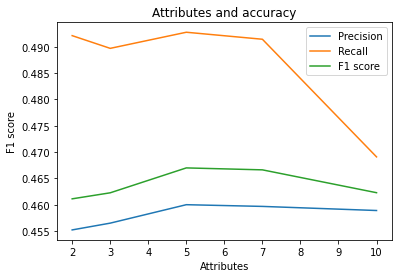

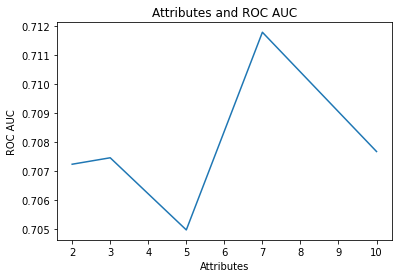

In [28]:

def plot_points(points):
    
    # Separate attributes
    a, p, r, f, o = [], [], [], [], []
    for i in range(len(points)):
        a.append(points[i][0])
        p.append(points[i][1])
        r.append(points[i][2])
        f.append(points[i][3])
        o.append(points[i][4])
    
    # Precision, recall and F1
    plt.plot(a, p, label = "Precision")
    plt.plot(a, r, label = "Recall")
    plt.plot(a, f, label = "F1 score")
    plt.title('Attributes and accuracy')
    plt.xlabel('Attributes')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()
    
    # ROC AUC
    plt.plot(a, o)
    plt.title('Attributes and ROC AUC')
    plt.xlabel('Attributes')
    plt.ylabel('ROC AUC')
    plt.show()

# Extra 7-attribute datapoint for more continuous line
gaussian7 = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['white_rating', 'black_rating', 'rating_delta', 'turns', 'opening_ply', 'eco', 'max_duration']
)

# Plot the line graphs
plot_points([gaussian10, gaussian7, gaussian5, gaussian3, gaussian2B])

## Additional observations

### Base ratings vs delta rating

Because delta_rating can be inferred from white_rating and black_rating, I had assumed it wouldn't provide any value to the classifier's output.  However, as can be seen below, switching these attributes for delta_rating actually improves the classifier's accuracy:

In [29]:
o = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['white_rating', 'black_rating', 'turns']
)

Attributes: 3
ROC AUC: 0.685
Class metrics:
 - Class 1: Precision: 0.44 Recall: 0.61 F1: 0.52
 - Class 2: Precision: 0.09 Recall: 0.21 F1: 0.13
 - Class 3: Precision: 0.77 Recall: 0.59 F1: 0.67
 - Average: Precision: 0.44 Recall: 0.47 F1: 0.44


In [30]:
o = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['rating_delta', 'turns']
)

Attributes: 2
ROC AUC: 0.707
Class metrics:
 - Class 1: Precision: 0.62 Recall: 0.61 F1: 0.61
 - Class 2: Precision: 0.08 Recall: 0.23 F1: 0.12
 - Class 3: Precision: 0.67 Recall: 0.64 F1: 0.65
 - Average: Precision: 0.46 Recall: 0.49 F1: 0.46


Improving the precision, recall and f1 score by 0.02 each, delta_rating provides better results than its component attributes - for Naive Bayes at least.  This is likely because the difference between players' skill is more important than the two evaluated separately.

Although this improves the output for Naive Bayes classification, I am unsure that it will help when using more advanced techniques that allow for a deeper understanding of complex relationships.

### Using turns to classify data


In [31]:
o = classifier_metrics(GaussianNB(), discrete, 'winner',
    ['turns']
)

Attributes: 1
ROC AUC: 0.589
Class metrics:
 - Class 1: Precision: 0.14 Recall: 0.43 F1: 0.21
 - Class 2: Precision: 0.08 Recall: 0.21 F1: 0.12
 - Class 3: Precision: 0.86 Recall: 0.51 F1: 0.64
 - Average: Precision: 0.36 Recall: 0.39 F1: 0.32


Using only the turns attribute to classify the data does not yield good results.  On average, it gives lower precision, recall and F1 score than any of the other configurations.  However, one metric is surprisingly high.

For class 3 (Black win), the precision for classification using only the turns attribute is higher than any other configuration.  This means that, if this model predicts a black win, it is likely to be true.

I believe what the classifier may be seeing in the data is a high correlation between zero-turn games and the white player timing out.  Because matchmaking can sometimes take a long time on lichess, players may be disconnecting or leaving before a game begins, resulting in a zero-turn game where white forfeits by time-out.

## Enhancing the data further

The opening codes used up until now cover a wide range very specific opening sequences, many of which are rarely or never seen.

For instance, here are three variations of the Queen's Gambit Declined, Slav defence:

 - D17 Czech defence:   d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4 Bf5
 - D18 Dutch variation: d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4 Bf5 6. e3
 - D19 Dutch variation: d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4 Bf5 6. e3 e6 7. Bxc4 Bb4 8. O-O

We can see that these openings are very similar as they only diverge after the 5th move.  However, the classifier can only see them as entirely separate, discrete openings.  In a perfect world, there would be enough instances for the classifier to learn their similarity but, as many of these openings only occur a few times, the classifier often doesn't make the connection.

What can be done to help this issue is to add another column with a more general opening code.  Hopefully this will allow the classifier to draw conclusions from the general opening if the specific one hasn't seen many instances.  I have copied opening data from https://www.365chess.com/eco.php and put it into a data file that can be read by this function:

In [32]:
def range_codes(range_code):
    """
    Convert a range code to set of individual codes
    For example:
        'A53' - > {'A53'}
        'A53-A55' - > {'A53', 'A54', 'A55'}
    """
    min_max = range_code.split("-")
    if len(min_max) == 1:
        return {range_code}
    
    elif len(min_max) == 2:
        letter = min_max[0][:1]
        min, max = int(min_max[0][1:]), int(min_max[1][1:])
        return { letter + f"{i:02d}" for i in range(min, max+1) }
    
    else:
        raise Exception("malformed range code")

def group_opening_codes(data, conversion_file):
    
    # Read conversion file
    opening_conversions = open('./data/opening_data.txt', 'r').read().splitlines()
    
    # Generate conversion map from file data
    conversion_map = {}
    for conversion in opening_conversions:
        split = conversion.split(" ", 1)
        range, name = split[0], split[1]
        
        for code in range_codes(range):
            conversion_map[code] = name
    
    # Add grouped column
    enhanced = data.copy()
    enhanced["grouped_eco"] = enhanced["eco"].apply( lambda code : conversion_map[code] )
    
    return enhanced
    
# Add new grouped_eco column
grouped = group_opening_codes( data, "./data/opening_data.txt" )

# Discretise and numberise data for bayes net
num_grouped = numberise(
    discretise(grouped),
    {'rated', 'status', 'white_rating', 'black_rating', 'rating_delta', 'eco', 'max_duration', 'grouped_eco'}
)

Now that the new column for a more general opening code has been added to the dataframe, we can run the bayes net again and hopefully see a classification accuracy improvement:

In [33]:
a = classifier_metrics(GaussianNB(), num_grouped, 'winner',
    ['eco']
)

Attributes: 1
ROC AUC: 0.517
Class metrics:
 - Class 1: Precision: 0.07 Recall: 0.48 F1: 0.13
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 0.93 Recall: 0.5 F1: 0.65
 - Average: Precision: 0.34 Recall: 0.33 F1: 0.26


In [34]:
b = classifier_metrics(GaussianNB(), num_grouped, 'winner',
    ['grouped_eco']
)

Attributes: 1
ROC AUC: 0.51
Class metrics:
 - Class 1: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 1.0 Recall: 0.5 F1: 0.67
 - Average: Precision: 0.33 Recall: 0.17 F1: 0.22


Using the grouped eco seems to do worse when used on its own.  Hopefully further analysis using Neural Networks later on will find the additional attribute advantageous.

## Linear regression

In [35]:
transformed = numberise(
    data,
    {'rated', 'eco', 'max_duration'}
)

In [36]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def classifier_score(classifier, data, class_name, attributes=None):
    
    # Optionally get subset of attributes for attributes selection
    if attributes != None:
        if class_name not in attributes:
            attributes.append(class_name)
        data = data[attributes]
    
    # Separate model data from output
    model = data.drop([class_name], axis=1)
    output = data[class_name]
    
    # Scale model
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(model)
    model = scaling.transform(model)
    
    # Get score
    scores = cross_val_score(classifier,
        model, output,
        scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    mean = scores.mean()
    
    # Derive accuracy from error and value range
    max_mean = ( data[class_name].max() - data[class_name].min() ) / 2
    accuracy = int( (max_mean-mean) / max_mean * 100 )
    
    classifier_name = str(classifier).split("(")[0]
    print( f"{classifier_name}: mean error: {mean:.2f}, accuracy: {accuracy}%" )
    return accuracy 

def classifier_scores(classifiers, data, class_name, attributes=None):
    print(f"=== class: {class_name} ===")
    out = []
    for classifier in classifiers:
        out.append( classifier_score(classifier, data, class_name, attributes) )
    print()
    return out

classifiers = [
    LinearRegression(),
    Lasso(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    # SVR(kernel="linear") # This take far too long and doesn't gove great results
]

ratings_removed = [
    "rated", "winner", "rating_delta", "eco", "opening_ply",
    "turns", "time", "increment", "max_duration"
]

#classes = ["winner", "rating_delta", "opening_ply", "turns", "time", "increment", "max_duration"]
classes = ["max_duration", "winner"]

scores = []
for c in classes:
    scores.append( classifier_scores(classifiers, transformed, c, ratings_removed) )

=== class: max_duration ===
LinearRegression: mean error: 333.80, accuracy: 65%
Lasso: mean error: 332.97, accuracy: 65%
DecisionTreeRegressor: mean error: 35.47, accuracy: 96%
RandomForestRegressor: mean error: 23.97, accuracy: 97%

=== class: winner ===
LinearRegression: mean error: 0.91, accuracy: 9%
Lasso: mean error: 0.98, accuracy: 2%
DecisionTreeRegressor: mean error: 1.08, accuracy: -8%
RandomForestRegressor: mean error: 0.80, accuracy: 19%



In [37]:
s = scores.copy()

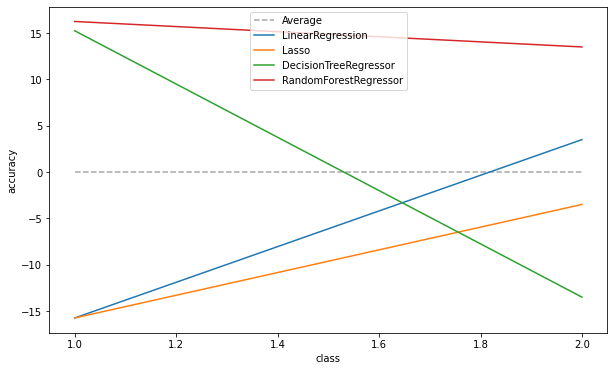

In [38]:
# Plot accuracy relative to average across classifers
for i in range(len(s)):
    mean = np.mean(s[i])
    s[i] = [x-mean for x in s[i]]

# Create plot axes
sT = np.array(s).T.tolist()
y = [i+1 for i in range(len(sT[0]))]

# Baseline
baseline = [0 for i in range(len(sT[0]))]
plt.figure(figsize=(10, 6))
plt.plot(y, baseline, '--', label="Average", color="darkgrey")

# Plot graph
classifer_names = [str(x).split("(")[0] for x in classifiers]
for i in range(len(classifer_names)):
    plt.plot(y, sT[i], label=classifer_names[i])
plt.ylabel("accuracy")
plt.xlabel("class")
plt.legend()
plt.show()

## Clustering

To analyse our data without supervision, we can use clustering.  Firstly, the data must be normalised:

In [39]:
# Normalise dataframe (adapted from https://stackoverflow.com/a/41532180)
def normalise(data):
    return (data-data.min()) / (data.max()-data.min()) * 0.99

# Create subset of data for clustering
cdata1 = normalise(data[["rating_delta", "opening_ply"]])
cdata2 = normalise(data[["turns", "time"]])
cdata3 = normalise(data[["white_rating", "increment"]])
cdata4 = normalise(data[["time", "winner"]])

This dataset doesn't lend itself particularly well to clustering, but there are a few patterns that can be seen in some columns:

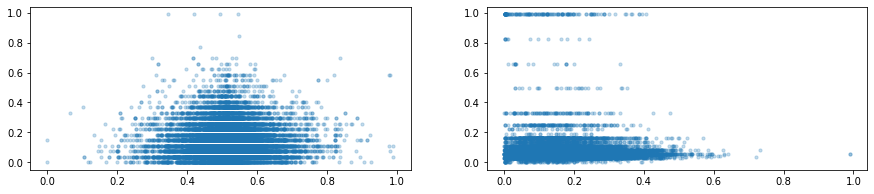

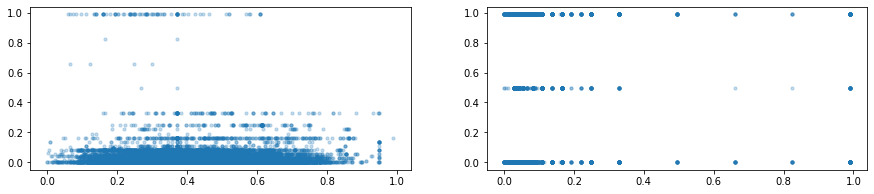

In [40]:
from matplotlib.pyplot import figure

# Plot normalised data
figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.scatter(cdata1.iloc[:,[0]], cdata1.iloc[:,[1]], alpha=0.25, s=10)
plt.subplot(1, 2, 2)
plt.scatter(cdata2.iloc[:,[0]], cdata2.iloc[:,[1]], alpha=0.25, s=10)
plt.show()
figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.scatter(cdata3.iloc[:,[0]], cdata3.iloc[:,[1]], alpha=0.25, s=10)
plt.subplot(1, 2, 2)
plt.scatter(cdata4.iloc[:,[0]], cdata4.iloc[:,[1]], alpha=0.25, s=10)
plt.show()

# cdata4 is most clustered
cdata = cdata4

Using the columns 'time' and 'winner', three horizontal clusters can be seen.  These clusters lean mostly to the left but extend all the way to the right of the graph.  No instances are seen in the middle of the plot which suggests that games with medium time constraints almost never draw.

One reason this may be the case is that fast games more often lead to accidental stalemates and slow games result in bored players mutually agreeing to stop, but moderately-paced games have less reason to draw.

### KMeans

KMeans clustering iteratively chooseses random centroids for the clusters and converges them using the mean point of all member instances.  By iteratively selecting and converging random selections over many iterations, KMeans often finds good results in spherically-clustered data.

Using the following code, we can see the rough regions decided for the clustering of data:

In [41]:
# Code from tutorial 4

def plot_data(X):
    plt.plot(X.iloc[:,[0]], X.iloc[:,[1]], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=1)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=1, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Using a KMeans clustering algorithm, we can see where the best locations are for the centroids of varying cluster counts:

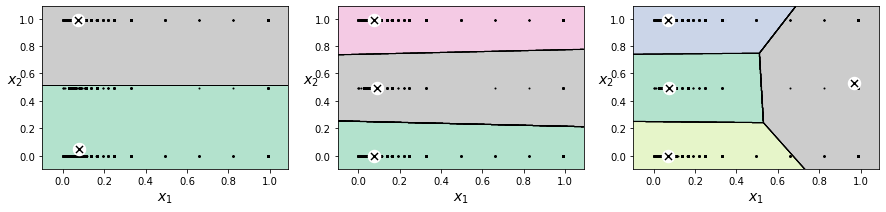

In [42]:
from sklearn.cluster import KMeans

figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(cdata)
plot_decision_boundaries(kmeans, cdata)

plt.subplot(1, 3, 2)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(cdata)
plot_decision_boundaries(kmeans, cdata)

plt.subplot(1, 3, 3)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(cdata)
plot_decision_boundaries(kmeans, cdata)

plt.show()

### Finding the best number of clusters

Although three clusters seems to be the most intuitive way of clustering this data, it would be useful to have a more objective measure.  One such measure is the negative inertia.

Inertia is the total distance between each instance and its cluster centre.  By using this as to refine cluster amounts, we can end up with very tightly grouped clusters.  The issue with this, however, is that more clusters always means a higher score; this would be one cluster for every single instance.

One solution to this issue is to look at the 'elbow' of the scores, plotted against the number of clusters.  By finding the point along the line where more clusters have significantly diminishing returns, you can find the optimal number of clusters.

Another measurement that can be used to evaluate clustering is by using the silhouette coefficient.  This uses the average inter-cluster and intra-cluster distances to evaluate how distinct the clusters are from each other.  Alongside being more objective than picking an 'elbow', this algorithm works on all clustering algorithms.

In [43]:
import time
from sklearn.metrics import silhouette_score

colourMap = ["red", "green", "blue", "magenta", "cyan", "yellow"]

def plotClusters(clusterer, X):
    y_pred = clusterer.fit_predict(X)
    colours = [colourMap[i] for i in y_pred]
    plt.scatter(X.iloc[:,[0]], X.iloc[:,[1]], alpha=1, s=8, c=colours)
    return

def basicScore(X, clusterer):
    clusterer.fit(X)
    return clusterer.score(X)

def silhouetteScore(X, clusterer):
    labels = clusterer.fit_predict(X)
    return silhouette_score(X, labels)

cluster_range = range(2,6+1) # try 2, 3 and 4 clusters

def plotClusterScores(X, clusterer, elbowClusters, peakClusters):
    
    clusterers = [clusterer(i) for i in cluster_range]
    start = time.time()
    basicScores = [ basicScore(X, clusterer) for clusterer in clusterers ]
    duration = time.time() - start
    silhouetteScores = [ silhouetteScore(X, clusterer) for clusterer in clusterers ]
    
    figure(figsize=(15, 3))
    plt.subplot(1, 3, 1)
    plt.plot(cluster_range, basicScores, "bo-")
    plt.ylabel("score")
    plt.xlabel("clusters")
    
    """plt.annotate(
        'Elbow',
         xy=(elbowClusters, basicScores[elbowClusters-cluster_range[0]]),
         xytext=(0.2, 0.5),
         textcoords='figure fraction',
         fontsize=16,
         arrowprops=dict(facecolor='black', shrink=0.1)
    )"""
    
    plt.subplot(1, 3, 2)
    plt.plot(cluster_range, silhouetteScores, "bo-")
    plt.ylabel("silhouette score")
    plt.xlabel("clusters")
    
    plt.subplot(1, 3, 3)
    plotClusters(clusterer(peakClusters), X)
    plt.show()
    print(f"Took {duration:.3} seconds")

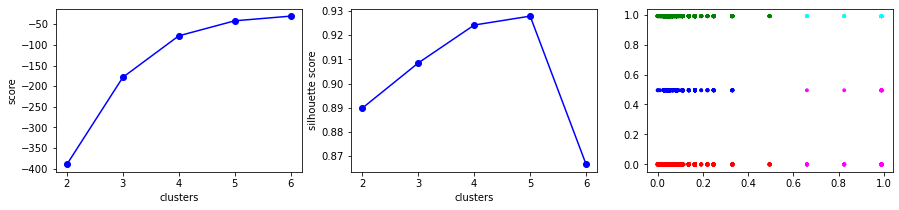

Took 0.428 seconds


In [44]:
kmeans = lambda n: KMeans(n_clusters=n, random_state=42)
plotClusterScores(cdata, kmeans, 3, 5)

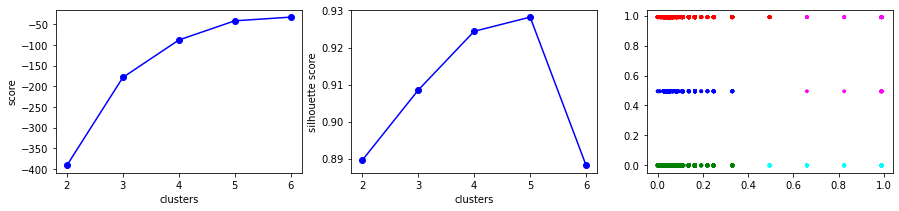

Took 0.216 seconds


In [45]:
from sklearn.cluster import MiniBatchKMeans

minikmeans = lambda n: MiniBatchKMeans(n_clusters=n, random_state=42, batch_size=3072)
plotClusterScores(cdata, minikmeans, 3, 5)

As can be seen in the above diagrams, KMeans and its mini-batch equivalent have very similar scores and clustering results.  The inertia for both methods doesn't have a distinct elbow but the value of increased clusters begins to diminish at around 3 or 4.  The silhouette coefficients for each cluster clearly suggest that 5 clusters is the best and the configuration of those clusters are seen in the rightmost plots.

In each of the 5-cluster configurations, the algorithm seems to group the high density areas on the left into 3 separate clusters, and uses 2 more clusters to represent the sparse areas on the right of the plot.

### Gaussian Mixture

Gaussian Mixture is a probabilistic algorithm that works best on gaussian-distributed attributes.  The elbow of the scoring plot for this algorithm is slightly more defined, but not by much.  What does stand out is a significantly different plot for the silhouette scores for each additional cluster.

The silhouette scoring for Gaussian Mixture suggests that the best number of clusters is 3.  This is much more in line with my initial assumptions and makes sense, given that the attributes do have a gaussian distribution.

A reason gaussian yields more intuitive results may be because the algorithm can skew its cluster zones;  while KMeans must have spherical clustering influences, gaussian can stretch to have ovals or lines.  The skewed spheres explain why Gaussian is much better able to cluster the horizontal lines.

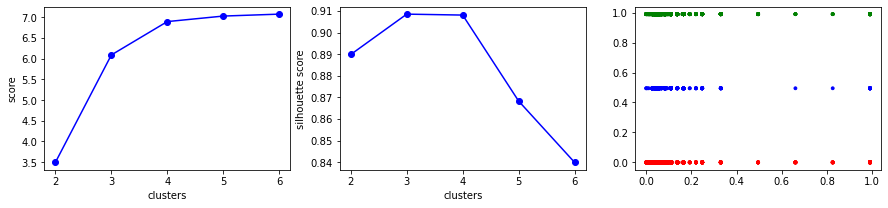

Took 0.539 seconds


In [46]:
from sklearn.mixture import GaussianMixture

gaussian = lambda n: GaussianMixture(n_components=n, random_state=42)
plotClusterScores(cdata, gaussian, 3, 3)

### Covariance matrices

For Gaussian Mixture, we can look at the covariance matrices for each cluster:

Cluster 1 (Red)
[[8.37754748e-03 0.00000000e+00]
 [0.00000000e+00 1.00000000e-06]]

Cluster 2 (Green)
[[8.49757780e-03 1.54995668e-32]
 [1.54995668e-32 1.00000000e-06]]

Cluster 3 (Blue)
[[ 1.80374376e-02 -6.74683669e-34]
 [-6.74683669e-34  1.00000000e-06]]


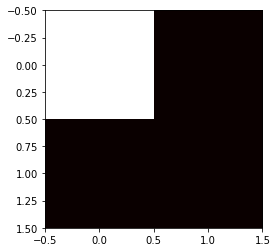

In [47]:
gauss = GaussianMixture(n_components=3, random_state=42)
gauss.fit(cdata)

print("Cluster 1 (Red)")
print(gauss.covariances_[0])

print("\nCluster 2 (Green)")
print(gauss.covariances_[1])

print("\nCluster 3 (Blue)")
print(gauss.covariances_[2])

plt.imshow(gauss.covariances_[0], cmap='hot', interpolation='nearest')
plt.show()

The covariance matrix for each of the clusters is very similar.

All three clusters have no covariance between time and winner at all.  This make sense as, within each cluster, there is only one value for winner and can therefore have no correlation with time.

The clusters also have a variance for winner of 1e-6.  This very small amount of variance will again be due to the fact that there is only one value for winner within each cluster.

Finally, the time variance of the clusters is similar for white wins and black wins, but slightly higher for draws.  This will likely be due to the fact that, as discussed earlier, drawn games often arise from long play times.

## Decision Trees

To classify the data, we can use a decision tree.  The J48 algorithm (C4.5) allows us to specify parameters such as tree depth and automatically create one with which to classify our data:

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(max_depth=2, random_state=42, min_samples_leaf=1)

out = classifier_metrics(
    tree, discrete, 'winner',
    ['white_rating', 'black_rating', 'turns'],
    folds=10
)

Attributes: 3
ROC AUC: 0.578
Class metrics:
 - Class 1: Precision: 0.23 Recall: 0.63 F1: 0.34
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 0.89 Recall: 0.53 F1: 0.66
 - Average: Precision: 0.37 Recall: 0.39 F1: 0.33


With a maximum tree depth of 2, the classifier doesn't do all too well.  We can, however, graph the decisions it's making:

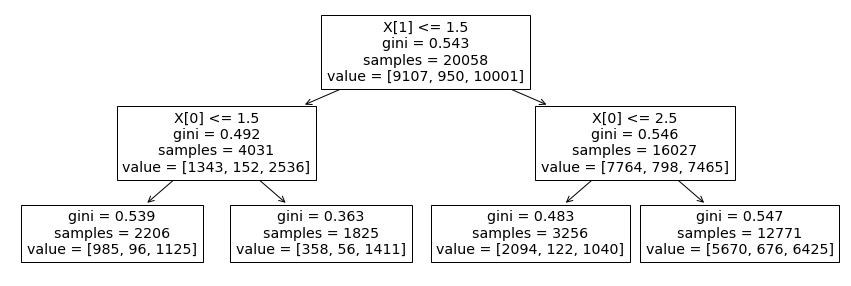

In [49]:
figure(figsize=(15, 5))
plot_tree(tree)
plt.show()

Initially using X[1] (black_rating) to split the data, the classifier then splits the data again using X[0] (white_rating).  This makes sense as, given a limited number of decisions, ratings are more important for classification than turn time.

### Higher tree depth

Though it can't be graphed, we can see how the tree performs when given a higher max depth of 40:

In [50]:
out = classifier_metrics(
    DecisionTreeClassifier(max_depth=40, random_state=42, min_samples_leaf=1), discrete, 'winner',
    ['white_rating', 'black_rating', 'turns'],
    folds=10
)

Attributes: 3
ROC AUC: 0.978
Class metrics:
 - Class 1: Precision: 0.8 Recall: 0.76 F1: 0.78
 - Class 2: Precision: 0.12 Recall: 0.17 F1: 0.14
 - Class 3: Precision: 0.78 Recall: 0.79 F1: 0.79
 - Average: Precision: 0.56 Recall: 0.57 F1: 0.57


When given a max depth of 40, the tree performs much better than before.  The F1 rating of 0.57 is is 21% higher than any  other classifier has achieved so far.

In [51]:
from sklearn.model_selection import train_test_split

def multi_scores(classifier, data, class_name, test_size=0.25):
    
    model = data.drop([class_name], axis=1)
    target = data[class_name]
    
    train_model, test_model = train_test_split( model, test_size=test_size, random_state=42)
    train_target, test_target = train_test_split( target, test_size=test_size, random_state=42)
    
    classifier.fit(train_model, train_target)
    
    return (
        classifier.score(train_model, train_target),
        classifier.score(test_model, test_target),
        np.mean(cross_val_score(classifier, train_model, train_target, cv=int(1/test_size), scoring="accuracy"))
    )

# Numberise data
ndata = numberise(data)

In [52]:
def smooth(l):
    return [ np.mean(l[i-1:i+2]) if (i>1)and(i<len(l)-1) else l[i] for i in range(len(l)) ]

def optimal_max_depth(classifier, data, class_name, depth_range):
    
    # Calculate accuracies
    scores, split_scores, cross_scores = [], [], []
    for i in depth_range:
        score, split_score, cross_score = multi_scores(classifier(i), data, class_name)
        scores.append( score )
        split_scores.append( split_score )
        cross_scores.append( cross_score )
    figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Accuracy per max_depth")
    plt.plot(depth_range, scores, label="non-split", c="red")
    plt.plot(depth_range, split_scores, label="test-train split", c="orange")
    plt.plot(depth_range, cross_scores, label="cross val", c="green")
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')
    plt.legend()
    
    ## Get the difference in accuracy between each max_depth increase
    score_delta = [ scores[i]-scores[i-1] if i>scores[0] else 0 for i in range(len(depth_range)) ]
    plt.subplot(1, 2, 2)
    plt.title("Accuracy rate per max_depth")
    plt.plot(depth_range, score_delta, c="cyan")

    # Average deltas with neighbours to smooth out graph
    smoothed_delta = smooth(smooth(score_delta))
    plt.plot(depth_range, smoothed_delta)

    # Get highest delta point
    max_index = np.argmax(smoothed_delta)
    max_depth = depth_range[max_index]
    max_value = smoothed_delta[max_index]
    plt.axvline(max_depth, c="green", linestyle='--')
    
    plt.xlabel('Max depth')
    plt.ylabel('Accuracy')

    plt.show()
    print(f"Optimal max_depth: {max_depth}")

### Split vs non-split data

The scores so far have been using multiple-fold cross validation so as to avoid overfitting.  However, we can graph scores achieved with cross validation, test-train-split data, and non-split data:

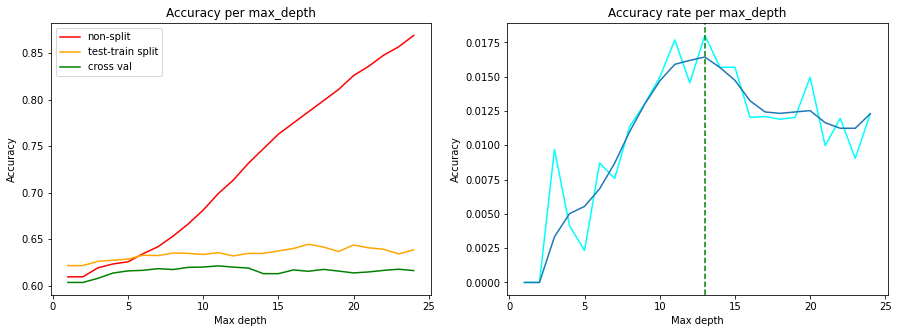

Optimal max_depth: 13


In [53]:
tree = lambda n: DecisionTreeClassifier(max_depth=n, random_state=42, min_samples_leaf=1)
optimal_max_depth( tree, ndata, "winner", range(1,25) )

The test-train-split data and the cross validation perform very similarly.  Improving only slightly with higher depth, they stay very stable.

The non-split data - trained and tested one dataset - tells a very different story.  With more depth, the non-split accuracy ratings soar.  This isn't because the classifier is getting better, however;  it's because the classifier is overfitting.  The fact that the same accuracies can't be achieved when the data is unseen shows that it's only learning the training set.

### Alleviating overfitting

The classifier is overfitting with high tree depth because it can focus on very small number of samples and create rules based on patterns only present in the training set.  this problem can be lessened by disallowing the dataset to make rules only applying to a few instances.

min_samples_leaf defines the minimum number of samples that a decision node can have.  By having a high minimum sample value, we can help to avoid classifier overfitting:

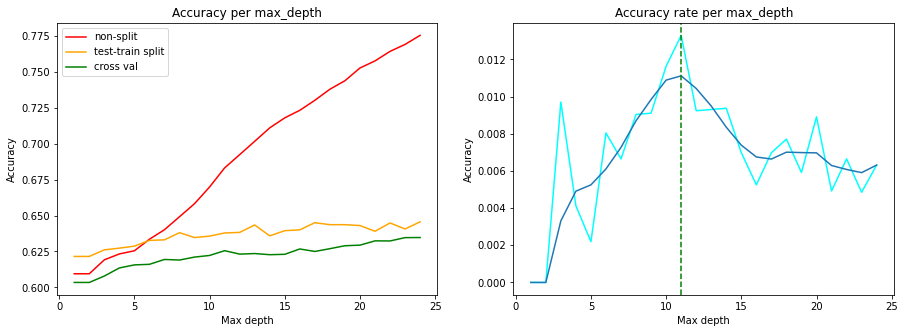

Optimal max_depth: 11


In [54]:
tree = lambda n: DecisionTreeClassifier(max_depth=n, random_state=42, min_samples_leaf=5)
optimal_max_depth( tree, ndata, "winner", range(1,25) )

As can be seen in the graphs above, the non-split data achieves a lower accuracy score and the split data receives a higher one.  This is because the non-split score was relying on overfitting to achieve high scores.

The graph on the right also shows the optimal max depth for non-split data as lower.  This is because it's getting less benefit from trying to overfit. 

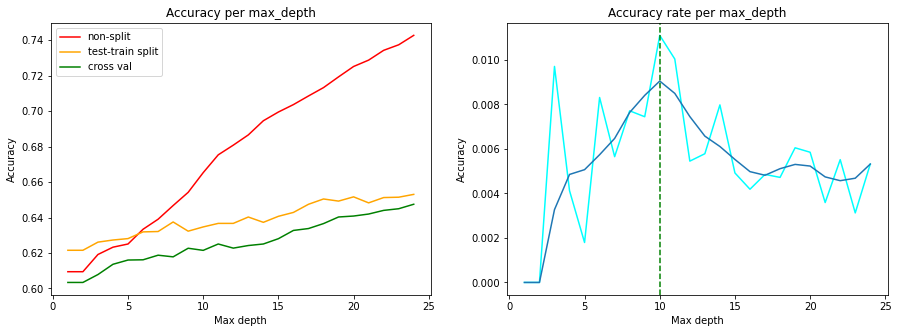

Optimal max_depth: 10


In [55]:
tree = lambda n: DecisionTreeClassifier(max_depth=n, random_state=42, min_samples_leaf=10)
optimal_max_depth( tree, ndata, "winner", range(1,25) )

Raising the min samples again, the accuracy gap between the split- and non-split-data reduces further.  With no overfitting, we should see no difference between the split- and non-split-data.

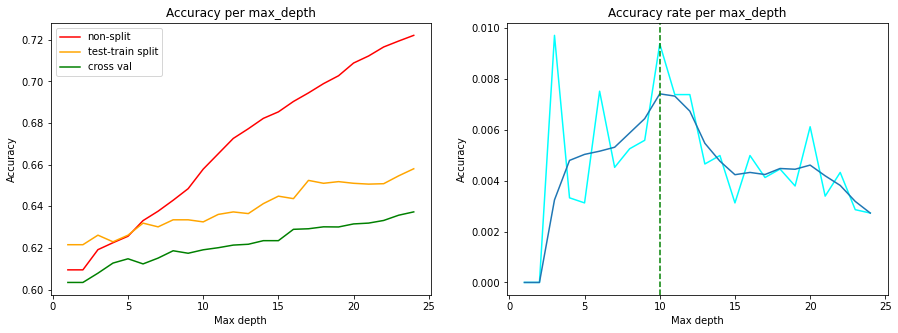

Optimal max_depth: 10


In [56]:
tree = lambda n: DecisionTreeClassifier(max_depth=n, random_state=42, min_samples_leaf=20)
optimal_max_depth( tree, ndata, "winner", range(1,25) )

In [57]:
def split_metrics(classifier, data, class_name):
    model = data.drop([class_name], axis=1)
    target = data[class_name]
    
    scores = []
    
    ran = range(1,100)
    
    for i in ran:
        split = i/100
        train_model, test_model = train_test_split( model, train_size=split, random_state=42)
        train_target, test_target = train_test_split( target, train_size=split, random_state=42)
        clsf = classifier()
        clsf.fit(train_model, train_target)
        scores.append( clsf.score(test_model, test_target) )
    
    plt.plot(ran, scores, c="cyan")
    plt.plot(ran, smooth(scores))
    plt.xlabel('Train size %')
    plt.ylabel('Accuracy')
    plt.show()

### Test-train split ratio

A factor that largely affects the overfitting of a classifier is training set size.  Plotting accuracy against training set size, we can see the effects:

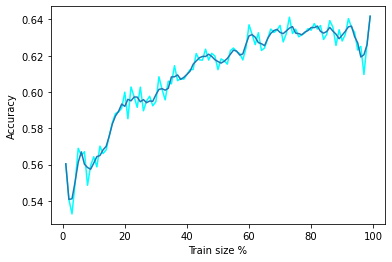

In [58]:
tree = lambda: DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_leaf=10)
split_metrics(tree, ndata, "winner")

With training set size of 1%, the accuracy is only ~55%.  Increasing the size of the training set clearly shows gradual improvement as the classifier has more data and can consequently better avoid overfitting.

At around 90% training set size, the accuracy begins fluctuate.  This seems to be because the test set reduces in size too much to give accurate measures.

### Random Forest

Random Forest classification uses feature randomness to separately build many different decision trees for the same problem.  When making a prediction, these trees all 'vote' for the most likely and the winner is chosen.  Running a decision tree against a random forest, we can see the results:

In [59]:
out = classifier_metrics(
    DecisionTreeClassifier(max_depth=40, random_state=42), discrete, 'winner',
    ['white_rating', 'black_rating', 'turns'],
    folds=10
)

Attributes: 3
ROC AUC: 0.978
Class metrics:
 - Class 1: Precision: 0.8 Recall: 0.76 F1: 0.78
 - Class 2: Precision: 0.12 Recall: 0.17 F1: 0.14
 - Class 3: Precision: 0.78 Recall: 0.79 F1: 0.79
 - Average: Precision: 0.56 Recall: 0.57 F1: 0.57


In [60]:
from sklearn.ensemble import RandomForestClassifier

out = classifier_metrics(
    RandomForestClassifier(max_depth=40, random_state=42), discrete, 'winner',
    ['white_rating', 'black_rating', 'turns'],
    folds=10
)

Attributes: 3
ROC AUC: 0.975
Class metrics:
 - Class 1: Precision: 0.76 Recall: 0.75 F1: 0.75
 - Class 2: Precision: 0.1 Recall: 0.17 F1: 0.13
 - Class 3: Precision: 0.79 Recall: 0.77 F1: 0.78
 - Average: Precision: 0.55 Recall: 0.56 F1: 0.55


The random forest does slightly worse.  This is because forests primarily get better results by lowering model instability.  As there are plenty of instances for the decision tree to train on, the resultant model isn't sufficiently unstable to be improved by random forest.  It also shows our model is not overfitting as it outperforms a classifier built on averaging across multiple rules.

### Additional observations

We can use the following function to plot the number of fold in cross validation against the accuracy they give:

In [61]:
def test_splits(classifier, data, classname):
    arr = []
    ran = range(2, 30)
    for folds in ran:
        first, *middle, last = classifier_metrics(classifier, data, classname, folds=folds, verbose=False)
        arr.append(middle)
    arrT = list(map(list, zip(*arr)))
    plt.plot(ran, arrT[0], label="precision")
    plt.plot(ran, arrT[1], label="recall")
    plt.plot(ran, arrT[2], label="f1 score")
    plt.legend()
    plt.xlabel('Folds')
    plt.ylabel('Accuracy')
    plt.show()
    return

# test_splits(DecisionTreeClassifier(max_depth=5, random_state=46, min_samples_leaf=1), ndata, 'winner')

In [62]:
def calc_accuracies(classifier, data, class_name, test_size=0.1, verbose=False):
    
    train_model, test_model = train_test_split( data.drop([class_name], axis=1), test_size=test_size, random_state=42)
    train_target, test_target = train_test_split( data[class_name], test_size=test_size, random_state=42)
    
    clsf = classifier()
    clsf.fit(train_model, train_target)
    
    cross = cross_val_score(clsf, train_model, train_target, cv=10, scoring="accuracy")
    out = (
        clsf.score(train_model, train_target),
        clsf.score(test_model, test_target),
        cross.mean(),
        cross.max() - cross.min()
    )
    
    if verbose:
        print( f"Accuracies predicting {class_name}: \n- Train: {out[0]:.2f} \n- Test: {out[1]:.2f} \n- Cross: {out[2]:.2f} ± {(out[3]/2):.2f}" )
    
    return out

## Perceptrons

Perceptrons use a biologically-inspired algorithm to replicate neurons in the brain.  They can be used to classify binary data.  Using non-split data, test-train-split data, and 10-fold cross validation, we can see the accuracy of a basic perceptron:

In [63]:
from sklearn.linear_model import Perceptron

perceptron = lambda: Perceptron(max_iter=1000, tol=1e-3, random_state=44)

ratings = calc_accuracies(perceptron, ndata, "winner", test_size=0.1, verbose=True)

Accuracies predicting winner: 
- Train: 0.62 
- Test: 0.62 
- Cross: 0.57 ± 0.09


With an accuracy score of ~60%, the perceptron does not seem as effective at classifying the data as other classifiers such as decision trees.

The split, non-split, and cross-validated accuracy scores are very similar.  This would suggest that the classifier is not overfitting to specific instances in the training set.

We can also see how varying the tet-train split affects the accuracy:

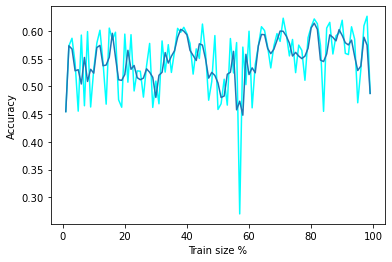

In [64]:
split_metrics(perceptron, ndata, "winner")

Unlike the decision tree, larger training sets have no impact on the accuracy of the model.  This suggests that it has a very low model complexity and requires few training instances to converge.

Another observation that can be made is that the model has quite low stability.  Over multiple different training instantiations, some have an accuracy as low as 25%.

## Multi-Layer Perceptrons

Layers of perceptrons can be combined together, each feeding into the next.  This means that non-linear relationships can be found in the data.

### Network shape

To discern the best number of layers, and how many nodes are in each of those layers, I have created an visualisation tool:

In [65]:
from sklearn.neural_network import MLPClassifier

def shape_metrics(classifier, data, class_name, layerRange, nodeRange):
    
    model = data.drop([class_name], axis=1)
    target = data[class_name]
    
    layerAccuracies = []
    for layers in layerRange:
                      
        nodeAccuracies = []
        for nodes in nodeRange:
                      
            shape = (nodes,)*layers
            clsf = classifier(shape)
            cross = cross_val_score(clsf, model, target, cv=3, scoring="accuracy")
            nodeAccuracies.append( cross.mean() )
            
        layerAccuracies.append( nodeAccuracies )
    
    return layerAccuracies

In [66]:
mlp = lambda shape: MLPClassifier(tol=1e-3, random_state=44, hidden_layer_sizes=shape)

# Get shape metrics - This call takes ~5 minutes so it's cached
layerRange = range(1,6,1)
nodeRange = range(3,16,3)
# metrics = shape_metrics(mlp, ndata, "winner", layerRange, nodeRange)
metrics = [
    [0.4981553494864892, 0.5682520689999003, 0.551700069797587,  0.6023033203709244, 0.6025027420480606],
    [0.5609731777844251, 0.6107787416492173, 0.6036494166915943, 0.555638647921029,  0.6098813441021039],
    [0.6204506929903281, 0.5805663575630672, 0.6017050553395155, 0.5727889121547513, 0.6115265729384783],
    [0.6159637052547612, 0.5835576827201117, 0.6236414398245089, 0.6054442117858211, 0.6139694884833982],
    [0.6115265729384785, 0.6167613919633065, 0.615863994416193,  0.5690996111277297, 0.6103798982949447]
]

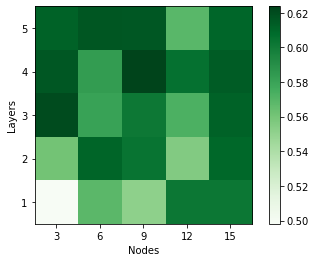

In [67]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(metrics[::-1], cmap='Greens', extent=[0,1,0,1])

y_label_list = [ i for i in layerRange ]
ax.set_yticks( [ (i-(layerRange[0]/2))/layerRange[-1] for i in layerRange ] )
ax.set_yticklabels(y_label_list)

x_label_list = [ i for i in nodeRange ]
ax.set_xticks( [ (i-(nodeRange[0]/2))/nodeRange[-1] for i in nodeRange ] )
ax.set_xticklabels(x_label_list)

plt.ylabel('Layers')
plt.xlabel('Nodes')
fig.colorbar(img)
plt.show()

In the heatmap above, we can see the resultant accuracies of different network shapes.  Along the y axis, the number of hidden layers is shown and, along the x axis, the number of nodes in each layer is shown.  Many other combinations are possible but, for the sake of simplicity, only rectangular shapes were tested.

The upper-left corner of the heatmap seems to show the best results.  This is where multiple layers of few nodes are used.  Two configurations that stand out are 3 layers of 3, and 4 layers of 9.

In [68]:
best = None
bestVal = 0
for layer_i in range(len(metrics)):
    layer = metrics[layer_i]
    for node_i in range(len(layer)):
        node = layer[node_i]
        if best is None or node > bestVal:
            best = layerRange[layer_i], nodeRange[node_i]
            bestVal = node
print(f"Best combination: {best[0]} layers, {best[1]} nodes: {bestVal:.2f} accuracy.")

Best combination: 4 layers, 9 nodes: 0.62 accuracy.


According to the heatmap, the best shape for this problem is 4 layers of 9 nodes.  It's also worth noting that a significantly simpler shape, 1x3, did the worst.  This would suggest that the data has higher complexity than only a few nodes can quantify.

### MLP accuracy

Similar to the single-layer perceptron, we can test the accuracy:

In [69]:
mlp_lambda = lambda: MLPClassifier(tol=1e-3, random_state=44, hidden_layer_sizes=4*(9,))
ratings = calc_accuracies(mlp_lambda, ndata, "winner", test_size=0.1, verbose=True)

Accuracies predicting winner: 
- Train: 0.62 
- Test: 0.61 
- Cross: 0.61 ± 0.02


In [70]:
mlp = MLPClassifier(tol=1e-3, random_state=44, hidden_layer_sizes=4*(9,))
c_metrics = classifier_metrics(mlp, ndata, "winner", folds=3)

Attributes: 10
ROC AUC: 0.699
Class metrics:
 - Class 1: Precision: 0.56 Recall: 0.63 F1: 0.59
 - Class 2: Precision: 0.0 Recall: 0.0 F1: 0.0
 - Class 3: Precision: 0.74 Recall: 0.62 F1: 0.67
 - Average: Precision: 0.43 Recall: 0.42 F1: 0.42


## Hyperparameters

Using the following tool to iterate over multiple parameter values and test the accuracies, we can see the effects of changing them:

In [71]:
def iterate_params(classifier, data, class_name, param_range):
    
    model = data.drop([class_name], axis=1)
    target = data[class_name]
    
    return [ np.mean(cross_val_score(classifier(param), model, target, cv=3, scoring="accuracy")) for param in param_range ]

def plot_params(accuracies, param_range):
    
    plt.plot(param_range, accuracies)

### Activation function

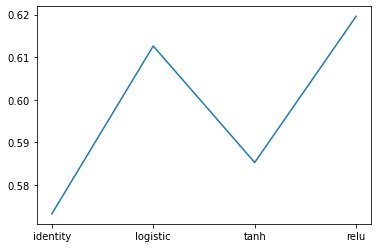

In [72]:
mlp_lambda = lambda param: MLPClassifier(random_state=42, hidden_layer_sizes=4*(9,), activation=param)
param_range = ["identity", "logistic", "tanh", "relu"]
# accuracies = iterate_params(mlp_lambda, ndata, "winner", param_range)
accuracies = [0.5732376109283078,0.6126233921627281,0.5853026223950543,0.6196031508624987]
plot_params(accuracies, param_range)
plt.show()

ReLU seems to do better than the other activation functions for this problem.  This may be because ReLU's characteristics allow it to converge faster then other methods for most conventional purposes.  ReLU is also better at traversing shallow gradients.

### Alpha

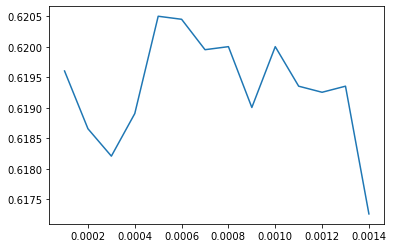

In [73]:
mlp_lambda = lambda param: MLPClassifier(random_state=42, hidden_layer_sizes=4*(9,), alpha=param)
param_range = [0.0001*i for i in range(1, 15)]
# accuracies = iterate_params(mlp_lambda, ndata, "winner", param_range)
accuracies = [0.6196031508624987,0.6186558978961013,0.6182071991225446,0.6189051749925217,0.6205005484096121,0.6204506929903281,0.6199521387974873,0.6200019942167714,0.6190048858310898,0.6200019942167714,0.6193538737660784,0.6192541629275102,0.6193538737660784,0.6172599461561471]
plot_params(accuracies, param_range)
plt.show()

Changing the alpha has only a tiny effect on the accuracy of the trained model, around 0.25%.  Nevertheless, the accuracy appears to be highest when the alpha is around 0.0005.

### Momentum

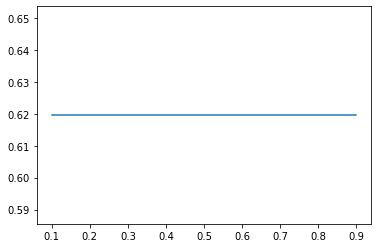

In [74]:
mlp_lambda = lambda param: MLPClassifier(random_state=42, hidden_layer_sizes=4*(9,), momentum=param)
param_range = [0.1*i for i in range(1, 10)]
# accuracies = iterate_params(mlp_lambda, ndata, "winner", param_range)
accuracies = [0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987]
plot_params(accuracies, param_range)
plt.show()

Changing the momentum of the MLP's gradient descent does not appear to affect its final accuracy rating.  This may be because the gradient is quite flat and, therefore, overshooting the local minima has little adverse effect.

### Validation fraction

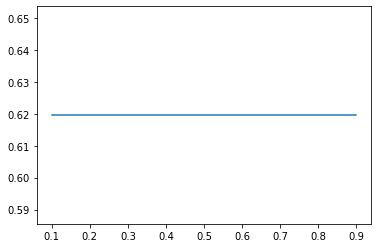

In [75]:
mlp_lambda = lambda param: MLPClassifier(random_state=42, hidden_layer_sizes=4*(9,), validation_fraction=param)
param_range = [0.1*i for i in range(1, 10)]
# accuracies = iterate_params(mlp_lambda, ndata, "winner", param_range)
accuracies = [0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987]
plot_params(accuracies, param_range)
plt.show()

Like momentum, changing the validation fraction appears to have no effect on the accuracy of the model.  This is likely to be for the same reason changing the perceptron's train-test split had no effect; the model requires very few instances to converge.

### Epochs

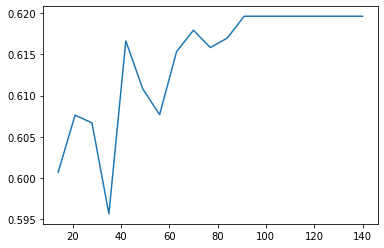

In [76]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

mlp_lambda = lambda param: MLPClassifier(random_state=42, hidden_layer_sizes=4*(9,), max_iter=param)
param_range = range(14, 141, 7)
# accuracies = iterate_params(mlp_lambda, ndata, "winner", param_range)
accuracies = [0.6007079469538339,0.6076378502343205,0.6066905972679231,0.5956725496061422,0.6166118257054541,0.6108285970685013,0.6076877056536044,0.6153155848040682,0.6179080666068403,0.615814138996909,0.6169608136404428,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987,0.6196031508624987]
plot_params(accuracies, param_range)
plt.show()

As expected, limiting the number of training epochs significantly reduces the accuracy of the trained model.  After around 90 epochs, however, the model converges and additional epochs have no effect.

### Putting it all together

Using the previous research on optimal hyperparameters, we can test the accuracy of an optimal model:

In [77]:
mlp_lambda = lambda: MLPClassifier(
    random_state=42,
    hidden_layer_sizes=4*(9,),
    activation="relu",
    alpha=0.0005,
    max_iter=150
)
ratings = calc_accuracies(mlp_lambda, ndata, "winner", test_size=0.1, verbose=True)
ratings = calc_accuracies(mlp_lambda, ndata[["winner", "rating_delta", "time"]], "winner", test_size=0.1, verbose=True)

Accuracies predicting winner: 
- Train: 0.62 
- Test: 0.61 
- Cross: 0.62 ± 0.03
Accuracies predicting winner: 
- Train: 0.62 
- Test: 0.61 
- Cross: 0.62 ± 0.02


The MLP does slightly better than the Perceptron.  This suggests that there is a little more complexity than the perceptron can handle - but not much.

### Dataset complexity

In the context of linear separability, the dataset is quite complex.  Classifying the winner with a linear classifier such as the perceptron only yields an accuracy of around 60%, though more advanced classifiers only reach about 65% at best.

### Generalisation of Neural Networks

From the experiments conducted on this dataset, neural networks seem very well-suited to generalising and predicting new data.  This is likely to be because they are usually quite simple.  Unlike decision trees with tens of thousands of nodes, neural networks with a few hundred nodes find it much harder to focus on specific features in the training set.

### Different activation functions

In previous experiments, it was shown that ReLU does better than the other activation functions for this problem, but it doesn't explain why.  A likely reason for this is ReLU's natural advantage when it comes to vanishing gradients.

Vanishing gradients is a term used for the result of the error gradient becoming insignificant, propagated over too many layers.  An experiment using logistic and ReLU below demonstrates the issue:

In [78]:
mlp_lambda = lambda: MLPClassifier( random_state=42, hidden_layer_sizes=5*(3,), activation="logistic", )
ratings = calc_accuracies(mlp_lambda, ndata, "winner", test_size=0.1, verbose=True)

mlp_lambda = lambda: MLPClassifier( random_state=42, hidden_layer_sizes=5*(3,), activation="relu", )
ratings = calc_accuracies(mlp_lambda, ndata, "winner", test_size=0.1, verbose=True)

Accuracies predicting winner: 
- Train: 0.50 
- Test: 0.50 
- Cross: 0.50 ± 0.00
Accuracies predicting winner: 
- Train: 0.62 
- Test: 0.60 
- Cross: 0.62 ± 0.03


The logistic-activated function has an accuracy of exactly 50% by every measure, while the ReLU-activated function has an accuracy of around 61%, about the same as the previous networks.  The difference between these activation functions is that the error propagated by sigmoid vanished over the layers, but the ReLU propagates further.

## Keras Neural Network

Using Keras instead of sklearn to create the network, we can better control the individual layers.

In [79]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
tf.keras.backend.set_floatx('float64')

# Convert pandas frame to tensor
tdata = normalise(ndata[["winner", "rating_delta", "white_rating", "black_rating", "time"]])

model = tf.convert_to_tensor( tdata.drop(["winner"], axis=1) )
target = tf.convert_to_tensor( tdata["winner"] )

model = tf.reshape(model, [20058, 1, 4])
target = tf.reshape(target, [20058, 1, 1])

In [80]:
# Create MLP model
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3,activation="relu"),
    tf.keras.layers.Dense(3,activation="relu"),
    tf.keras.layers.Dense(3,activation="softmax")
])
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'mse'])
metrics = mlp.fit(model, target, epochs=3, batch_size=2)
print( f"Accuracy: {metrics.history['accuracy'][0]:.2f}" )

Epoch 1/3
10029/10029 [==============================] - 7s 725us/step - loss: 0.0222 - accuracy: 0.4534 - mse: 0.4811
Epoch 2/3
10029/10029 [==============================] - 6s 613us/step - loss: 2.9615e-07 - accuracy: 0.4540 - mse: 0.4889
Epoch 3/3
10029/10029 [==============================] - 6s 618us/step - loss: 2.0053e-07 - accuracy: 0.4540 - mse: 0.4889
Accuracy: 0.45


In [81]:
# Create CNN model
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(10, 1, activation='relu', input_shape=(1,4)),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Dense(3,activation="relu"),
    tf.keras.layers.Dense(3,activation="relu"),
    tf.keras.layers.Dense(3,activation="softmax")
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'mse'])
metrics = cnn.fit(model, target, epochs=3, batch_size=2)
print( f"Accuracy: {metrics.history['accuracy'][0]:.2f}" )

Epoch 1/3
10029/10029 [==============================] - 7s 673us/step - loss: 0.0035 - accuracy: 0.4540 - mse: 0.4872
Epoch 2/3
10029/10029 [==============================] - 7s 696us/step - loss: 2.2727e-07 - accuracy: 0.4540 - mse: 0.4889
Epoch 3/3
10029/10029 [==============================] - 7s 694us/step - loss: 2.0017e-07 - accuracy: 0.4540 - mse: 0.4889
Accuracy: 0.45


In [82]:
# Create CNN model
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(10, 1, activation='relu', input_shape=(1,4)),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Conv1D(30, 1, activation='relu', input_shape=(1,4)),
    tf.keras.layers.MaxPooling1D(1),
    tf.keras.layers.Dense(3,activation="relu"),
    tf.keras.layers.Dense(3,activation="relu"),
    tf.keras.layers.Dense(3,activation="softmax")
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'mse'])
metrics = cnn.fit(model, target, epochs=3, batch_size=2)
print( f"Accuracy: {metrics.history['accuracy'][0]:.2f}" )

Epoch 1/3
10029/10029 [==============================] - 8s 830us/step - loss: 0.0113 - accuracy: 0.4533 - mse: 0.4858
Epoch 2/3
10029/10029 [==============================] - 8s 785us/step - loss: 2.1500e-07 - accuracy: 0.4540 - mse: 0.4889
Epoch 3/3
10029/10029 [==============================] - 8s 812us/step - loss: 2.0004e-07 - accuracy: 0.4540 - mse: 0.4889
Accuracy: 0.45


None of the convolutional or pooling layers seem to add any accuracy to the model.  This is because there are no spacial features in the dataset.  The pixels in image data are closely related to the pixels in their immediate vicinity, but the attributes in this data set are entirely unrelated.